# Loteca

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Ler arquivo

In [2]:
df = np.load('arquivo.npy')

In [3]:
for i in range(len(df)):
    df[i,8] = 'H' if (int(df[i,2]) - int(df[i,6])) > 0 else 'A' if (int(df[i,2]) - int(df[i,6])) < 0 else 'D'


In [122]:
df_ = pd.DataFrame(df,columns=['Concurso','Jogo','HG','Home','S','Away','AG','Dia','Res'])

In [123]:
df_ = df_.astype({"HG": int, "AG": int})

In [124]:
df_.head()

,Concurso,Jogo,HG,Home,S,Away,AG,Dia,Res
0,Concurso 1 (18/02/2002),1,2,FLAMENGO/RJ,,S. PAULO/SP,4,Domingo,A
1,Concurso 1 (18/02/2002),2,3,VASCO/RJ,,AMERICANO/RJ,0,Domingo,H
2,Concurso 1 (18/02/2002),3,2,SANTOS/SP,,SÃO CAETANO/SP,1,Domingo,H
3,Concurso 1 (18/02/2002),4,1,P. DESPORTOS/SP,,CORINTHIANS/SP,4,Domingo,A
4,Concurso 1 (18/02/2002),5,7,CRUZEIRO/MG,,AMÉRICA/MG,0,Sábado,H


### Frequencia de vitórias em casa (H), empates (D) e visitantes (A)

<BarContainer object of 3 artists>

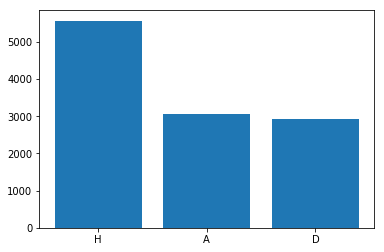

In [83]:
plt.bar(df_['Res'].value_counts().keys(),df_['Res'].value_counts())

### Nomes dos times

In [125]:
vocab = np.unique(np.concatenate((np.array(df_['Home'].unique()), np.array(df_['Away'].unique()))))

### Soma de gols dos últimos jogos

In [241]:
# Calcula a soma de gols feitos das ultimas n (window) partidas

def get_rolling_mean(dataFrame, equip, pos, window, HG_AG):   
    HA = 'Home' if HG_AG == 'HG' else 'Away' if HG_AG == 'AG' else ''
    s = dataFrame[-pos-window:-window][dataFrame[HA] == equip][HG_AG].sum()
    return s if not(np.isnan(s)) else 0

# Calcula a soma de gols recebidos das ultimas n (window) partidas
def get_rolling_received(dataFrame, equip, pos, window, HG_AG):   
    HA = 'Home' if HG_AG == 'HG' else 'Away' if HG_AG == 'AG' else ''
    HG_AG_ = 'HG' if HG_AG == 'AG' else 'AG' if HG_AG == 'HG' else ''
    s = dataFrame[-pos-window:-window][dataFrame[HA] == equip][HG_AG_].sum()
    return s if not(np.isnan(s)) else 0

    

In [243]:
print(get_rolling_mean(df_, 'ATLÉTICO/MG', 500, 20, 'AG'))
print(get_rolling_received(df_, 'ATLÉTICO/MG', 500, 20, 'AG'))


12
16


C:\ProgramData\Miniconda3\envs\loteca\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\ProgramData\Miniconda3\envs\loteca\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [127]:
# Cria o indice de times
word2idx = {word: i for i, word in enumerate(vocab)}

In [128]:
# Retorna o indice de um time:
def word2vector(word):
    m = np.zeros(len(word2idx))
    m[word2idx.get(word)] = 1
    return m.tolist()

In [246]:
# Transforma os dois times em um vetor com o flag do time correspondente e a média de gols
def prepare(H,A,pos):
    
    vector = []
    
    for x in word2vector(H):
        vector.append(x)
        
    for x in word2vector(A):
        vector.append(x)
        
    
#     vector.append(word2vector(H))
#     vector.append(word2vector(A))
    
#     vector = np.array(vector).reshape(1828)
    
    vector.append(get_rolling_mean(df_, H, pos, 10, 'HG'))
    vector.append(get_rolling_mean(df_, A, pos, 10, 'AG'))
    
    vector.append(get_rolling_received(df_, H, pos, 10, 'HG'))
    vector.append(get_rolling_received(df_, A, pos, 10, 'AG'))

    
#     return [vector, get_rolling_mean(df_, H, pos, 10, 'HG'), get_rolling_mean(df_, A, pos, 10, 'AG')]

    return vector

### Indexar os resultados

In [247]:
X = []
y = []

for ind_, row in df_.iterrows():
    X.append(prepare(row['Home'], row['Away'], ind_))        
    
    ry = [1,0,0] if int(row['HG']) > int(row['AG']) else \
    [0,1,0] if int(row['HG']) == int(row['AG']) else \
    [0,0,1] if int(row['HG']) < int(row['AG']) else [0,0,0]

    y.append(ry)

y = np.array(y).reshape(np.array(y).shape[0],5)

X = np.array(X)

# Normalizar gols
X[:,-4:-3] = X[:,-4:-3]/X[:,-4:-3].max()
X[:,-3:-2] = X[:,-3:-2]/X[:,-3:-2].max()
X[:,-2:-1] = X[:,-2:-1]/X[:,-2:-1].max()
X[:,-1:] = X[:,-1:]/X[:,-1:].max()



C:\ProgramData\Miniconda3\envs\loteca\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\ProgramData\Miniconda3\envs\loteca\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


### Modelo

In [248]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

model = Sequential()
model.add(Dense(124, input_shape=(np.array(X).shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Flatten())
model.add(Dense(5))
model.add(Activation('sigmoid'))

In [249]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Separar os datasets de treinamento e teste

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

### Treinar o modelo

In [251]:
model.fit(X_train, y_train, epochs=2000, batch_size=4000)

ValueError: Error when checking target: expected activation_10 to have shape (5,) but got array with shape (3,)

In [225]:
model.evaluate(X_test, y_test, verbose=1)

3815/3815 [==============================] - 1s 179us/step


[1.7304257945339458, 0.6259502097944757]

In [226]:
model.predict(X_[0].reshape(1,1830))

array([[0.62420875, 0.15302078, 0.24175502]], dtype=float32)

### Avaliar precisão

In [227]:
dfx = df_[int(-df_.shape[0]/20):]

ds = []

X_ = X[-int(X.shape[0]/20):]

prec = []

i=0
for idx, dfr in dfx.iterrows():

    p = model.predict(X_[i].reshape(1,X_.shape[1]))
    
    i =+ 1
    
    if p[0,0] > p[0,1] and p[0,0] > p[0,2]:
        px = 'H'
        
    if p[0,2] > p[0,1] and p[0,2] > p[0,0]:
        px = 'A'
        
    if p[0,1] > p[0,0] and p[0,1] > p[0,2]:
        px = 'D'
    
    prec.append(1 if px == dfr['Res'] else 0)
    
    dfr['S'] = 'G' if px == dfr['Res'] else 'P'
    
    ds.append(dfr)
    
dfs = pd.DataFrame(ds)

print(round((abs(np.mean(prec))) * 100,0), '%')
    

47.0 %


In [228]:
dfs.head()

,Concurso,Jogo,HG,Home,S,Away,AG,Dia,Res
10982,Concurso 785 (05/02/2018),11,0,CRICIÚMA/SC,P,AVAÍ/SC,1,Domingo,A
10983,Concurso 785 (05/02/2018),12,3,MONACO/FRA,G,LYON/FRA,2,Domingo,H
10984,Concurso 785 (05/02/2018),13,5,ARSENAL/ING,G,EVERTON/ING,1,Sábado,H
10985,Concurso 785 (05/02/2018),14,2,LIVERPOOL/ING,P,TOTTENHAM/ING,2,Domingo,D
10986,Concurso 786 (14/02/2018),1,0,MIRASSOL/SP,P,PALMEIRAS/SP,2,Sábado,A


In [229]:
dfs[dfs['S']=='G'].groupby(['Concurso'])['S'].value_counts()

Concurso                   S
Concurso 785 (05/02/2018)  G     2
Concurso 786 (14/02/2018)  G     9
Concurso 787 (20/02/2018)  G     5
Concurso 788 (26/02/2018)  G     7
Concurso 789 (05/03/2018)  G     6
Concurso 790 (12/03/2018)  G     3
Concurso 791 (19/03/2018)  G     5
Concurso 792 (26/03/2018)  G     9
Concurso 793 (02/04/2018)  G     7
Concurso 794 (09/04/2018)  G     7
Concurso 795 (16/04/2018)  G    11
Concurso 796 (23/04/2018)  G     6
Concurso 797 (30/04/2018)  G     3
Concurso 798 (07/05/2018)  G     6
Concurso 799 (14/05/2018)  G     8
Concurso 800 (21/05/2018)  G     8
Concurso 801 (28/05/2018)  G     5
Concurso 802 (04/06/2018)  G     5
Concurso 803 (11/06/2018)  G     6
Concurso 804 (18/06/2018)  G     5
Concurso 805 (25/06/2018)  G     8
Concurso 806 (28/06/2018)  G     1
Concurso 807 (02/07/2018)  G     6
Concurso 808 (09/07/2018)  G     7
Concurso 809 (16/07/2018)  G     6
Concurso 810 (23/07/2018)  G    10
Concurso 811 (30/07/2018)  G     8
Concurso 812 (06/08/2018) 

<BarContainer object of 2 artists>

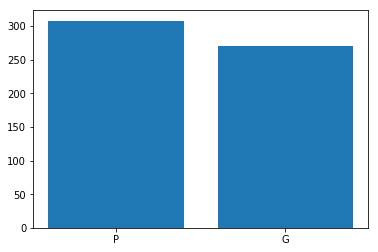

In [230]:
plt.bar(dfs['S'].value_counts().keys(),dfs['S'].value_counts())

### Lista de times

In [ ]:
vocab

### Realizar previsão

In [79]:
H = 'ATLÉTICO/MG'
A = 'SANTOS/SP'

prep = [prepare(H,A)]
    
prepx = np.array(prep).reshape(np.array(prep).shape[0],np.array(prep).shape[1]*2)
    
p = model.predict(prepx)


print(p)


TypeError: prepare() missing 1 required positional argument: 'pos'